# Predicting Customer Buying Behaviour

### Functions to Use

In [91]:
def evaluation_confusion_matrix(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    accuracy=accuracy_score(y_test,y_pred)
    print('accuracy', accuracy*100)
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    n,train_score,validation_score= learning_curve(model,x_train,y_train,cv=4,scoring='f1')
    plt.figure(figsize=(12,8))
    plt.title(model)
    plt.plot(n,train_score.mean(axis=1),label='train score')
    plt.plot(n,validation_score.mean(axis=1),label='validation score')
    plt.legend() 

# I-Libraries Importing

In [92]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import learning_curve
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import warnings
import seaborn as sns 
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import accuracy_score

In [93]:
warnings.filterwarnings("ignore")

# II-Data Importing

In [94]:
df=pd.read_csv(r'C:\Users\chene\Downloads\customer_booking (3).csv',encoding='windows-1251')

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

In [95]:
df.head(3)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0


# III-Data Analysis

In [96]:
print('Data Size:',df.shape)

Data Size: (50000, 14)


In [97]:
print('Features Type\n\n',df.dtypes)

Features Type

 num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object


In [98]:
print('No null variables\n\n',df.isnull().sum())

No null variables

 num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


In [99]:
duplicates = df.duplicated().sum()
print('Total duplicates:',duplicates)

Total duplicates: 719


#### we have a labelled data-set with no null variables ,but with duplicates we do have 5 Categorical and 9 numerical features

In [100]:
x=df[df['booking_complete']==0].count()
print('The total unbooked flights:',x['booking_complete']) # 42522

The total unbooked flights: 42522


In [101]:
x=df[df['booking_complete']==1].count()
print('The total booked flights:',x['booking_complete'])# 7478 completed their booking

The total booked flights: 7478


#### 85 % of the customers did not complete their booking and 15 % of them did  , we do have an unbalanced data

## 1-Numerical Features Analysis

In [102]:
df[df['booking_complete']==1].mean() 

num_passengers            1.649906
purchase_lead            80.167157
length_of_stay           19.617679
flight_hour               9.158331
wants_extra_baggage       0.745253
wants_preferred_seat      0.351565
wants_in_flight_meals     0.458411
flight_duration           6.898258
booking_complete          1.000000
dtype: float64

In [103]:
df[df['booking_complete']==0].mean() 

num_passengers            1.580923
purchase_lead            85.779926
length_of_stay           23.647218
flight_hour               9.050162
wants_extra_baggage       0.655331
wants_preferred_seat      0.287357
wants_in_flight_meals     0.421641
flight_duration           7.344266
booking_complete          0.000000
dtype: float64

Text(0.5, 1.0, 'Feature correlation')

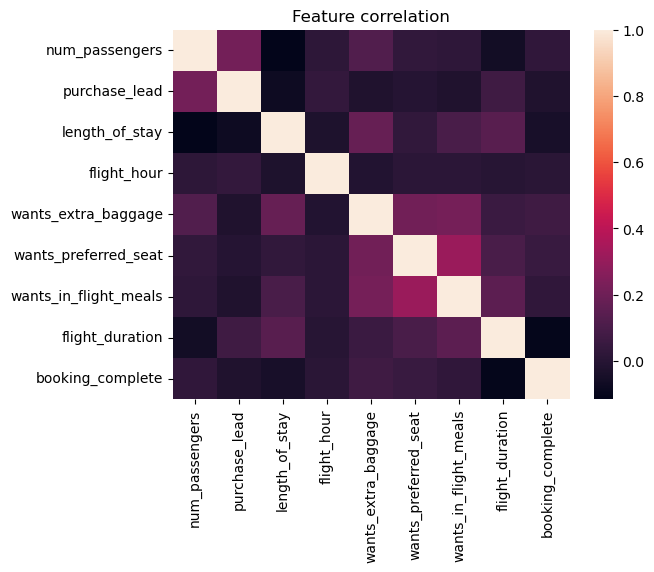

In [104]:
plt.figure()
sns.heatmap(df[df.columns[df.dtypes!=object]].corr())
plt.title('Feature correlation')

#### The average values for booked and unbooked flights are approximately in the same range, mainly passenger_number, flight time features.
#### The highest correlation is between `wants_in_flight_mealsand` and `wants_preferred_seat` otherwise there is no significant correlation between the other features

### `Purchase_lead/Target`

In [105]:
print('mean value of the purchase_lead:',df['purchase_lead'].mean())

mean value of the purchase_lead: 84.94048


In [106]:
x=df[df['booking_complete']==0]
y=x[x['purchase_lead']>84.940480] 
print(len(y))

14554


In [107]:
x=df[df['booking_complete']==1]
y=x[x['purchase_lead']>84.940480]
print(len(y))

2310


#### 34% of the unbooked flights have purchase lead superior than 85 days and approximatly the same percentage for the booked ones ,there is no difference .

### `Flight duration/Target `

In [108]:
print('mean value of the flight duration:',df['flight_duration'].mean())

mean value of the flight duration: 7.277560799998812


In [109]:
x=df[df['booking_complete']==1]
y=x[x['length_of_stay'] <7.277560799998812] #63% of the booked flight has flight duration <7.27
print(len(y))

4731


In [110]:
x=df[df['booking_complete']==0]
y=x[x['length_of_stay'] <7.277560799998812]
print(len(y))# 46% cancelled booked have flight duration <7.27

19942


#### When the flight duration is less then 7 hours , 46% of the customers don't complete their booking while 63% of them do. This feature has an influence on the target variable.

###  `Length_of_stay/Target`

In [111]:
print('mean value of the length_of_stay:',df['length_of_stay'].mean())

mean value of the length_of_stay: 23.04456


In [112]:
x=df[df['booking_complete']==0]
y=x[x['length_of_stay']<23.044560]
print(len(y))

28369


In [113]:
x=df[df['booking_complete']==1]
y=x[x['length_of_stay']< 23.044560]
print(len(y))

5665


#### When the length of stay is less than 23.04 , 75% of the customers complete their booking and 66% don't.
#### So this feature has a significant relationship with the target variable.

### `num_passengers/Target`

In [114]:
x=df[df['booking_complete']==1].groupby('num_passengers').count()
x['booking_complete']

num_passengers
1    4455
2    2051
3     491
4     275
5     109
6      54
7      18
8      12
9      13
Name: booking_complete, dtype: int64

In [115]:
x=df[df['booking_complete']==0].groupby('num_passengers').count()
x['booking_complete']

num_passengers
1    26897
2    10753
3     2450
4     1509
5      452
6      235
7       96
8       77
9       53
Name: booking_complete, dtype: int64

#### The num_passengers has no influence in the customer decision.

## 2-Categorical Features Analysis

### `Trip_type\Target`

In [116]:
x=df[df['booking_complete']==0]
y=x[x['trip_type']=='RoundTrip']
print(len(y))# from 42522 unbooked flightswe have 42044 their trip-type:round tripe

42044


In [117]:
x=df[df['booking_complete']==1]
y=x[x['trip_type']=='RoundTrip']
print(len(y))# from 7478 booked flights we have 7453 their trip-type:round tripe 

7453


#### Most of the trip_type are 'Round_tripe' whether they are booked or not so The trip_type and also the sales_channel have no influence in the booking_complete action .

### `Booking_origin\Target`

In [118]:
x=df[df['booking_complete']==1].groupby('booking_origin').count()
x=x[x['booking_complete']>100]
y=df[df['booking_complete']==0].groupby('booking_origin').count()
y=y[y['booking_complete']>100]

Text(0.5, 1.0, 'The booked flights compared to the booking_origin')

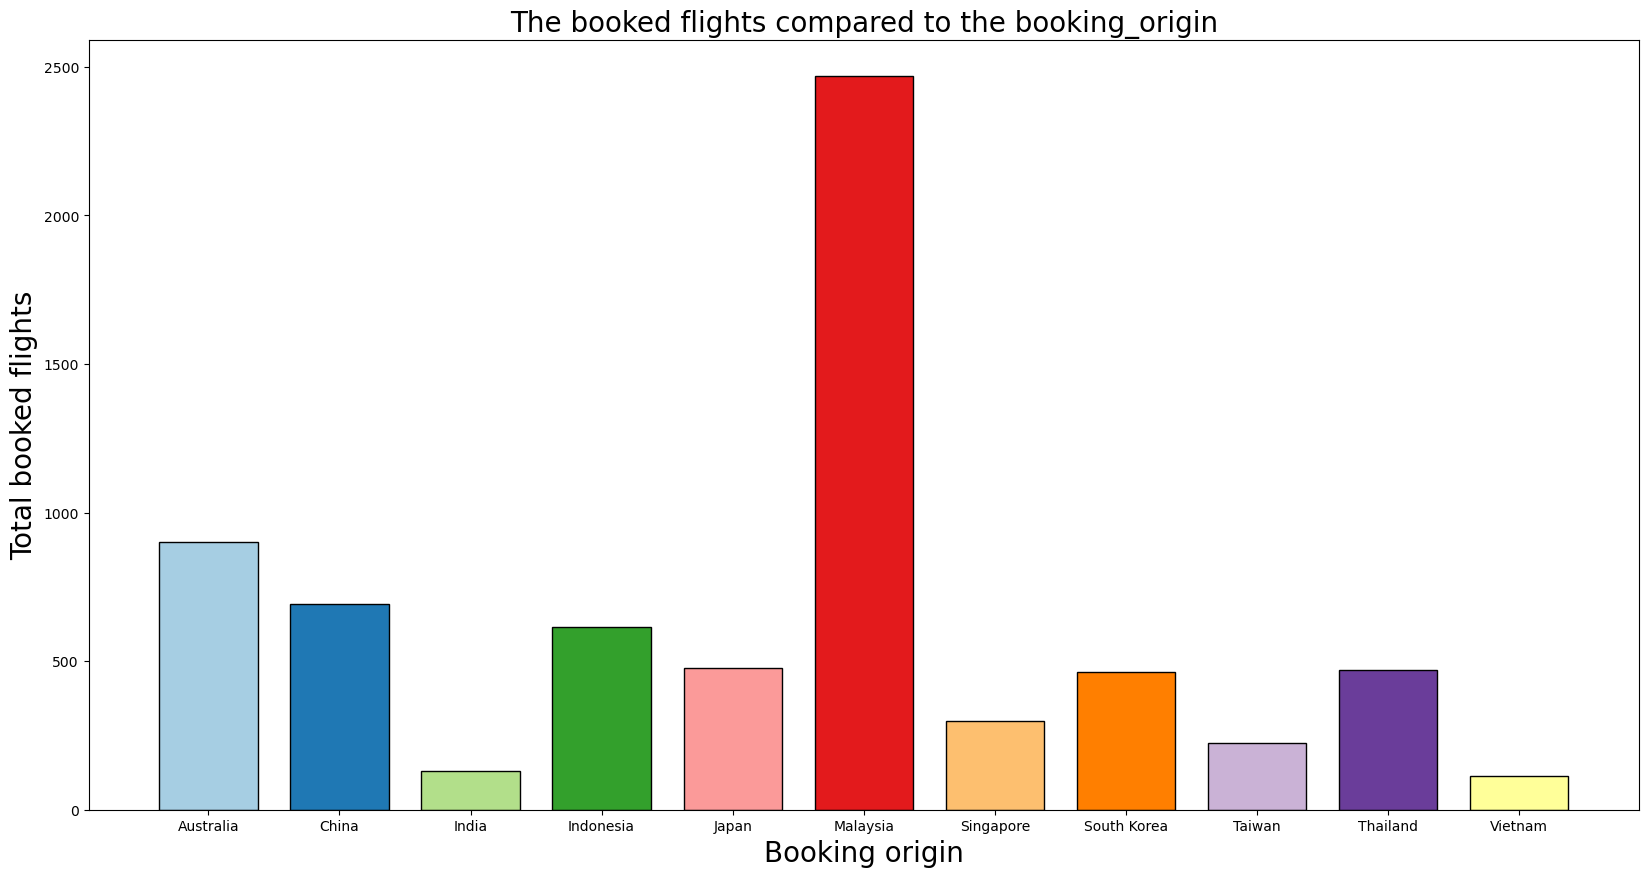

In [119]:
col_map = plt.get_cmap('Paired')
plt.figure(figsize=(20,10))
plt.bar(x.index,x['booking_complete'], width=0.75, color=col_map.colors, edgecolor='k')
plt.xlabel('Booking origin',fontsize=20)
plt.ylabel('Total booked flights',fontsize=20)
plt.title('The booked flights compared to the booking_origin',fontsize=20 )

Text(0.5, 1.0, 'The unbooked flights compared to the booking_origin')

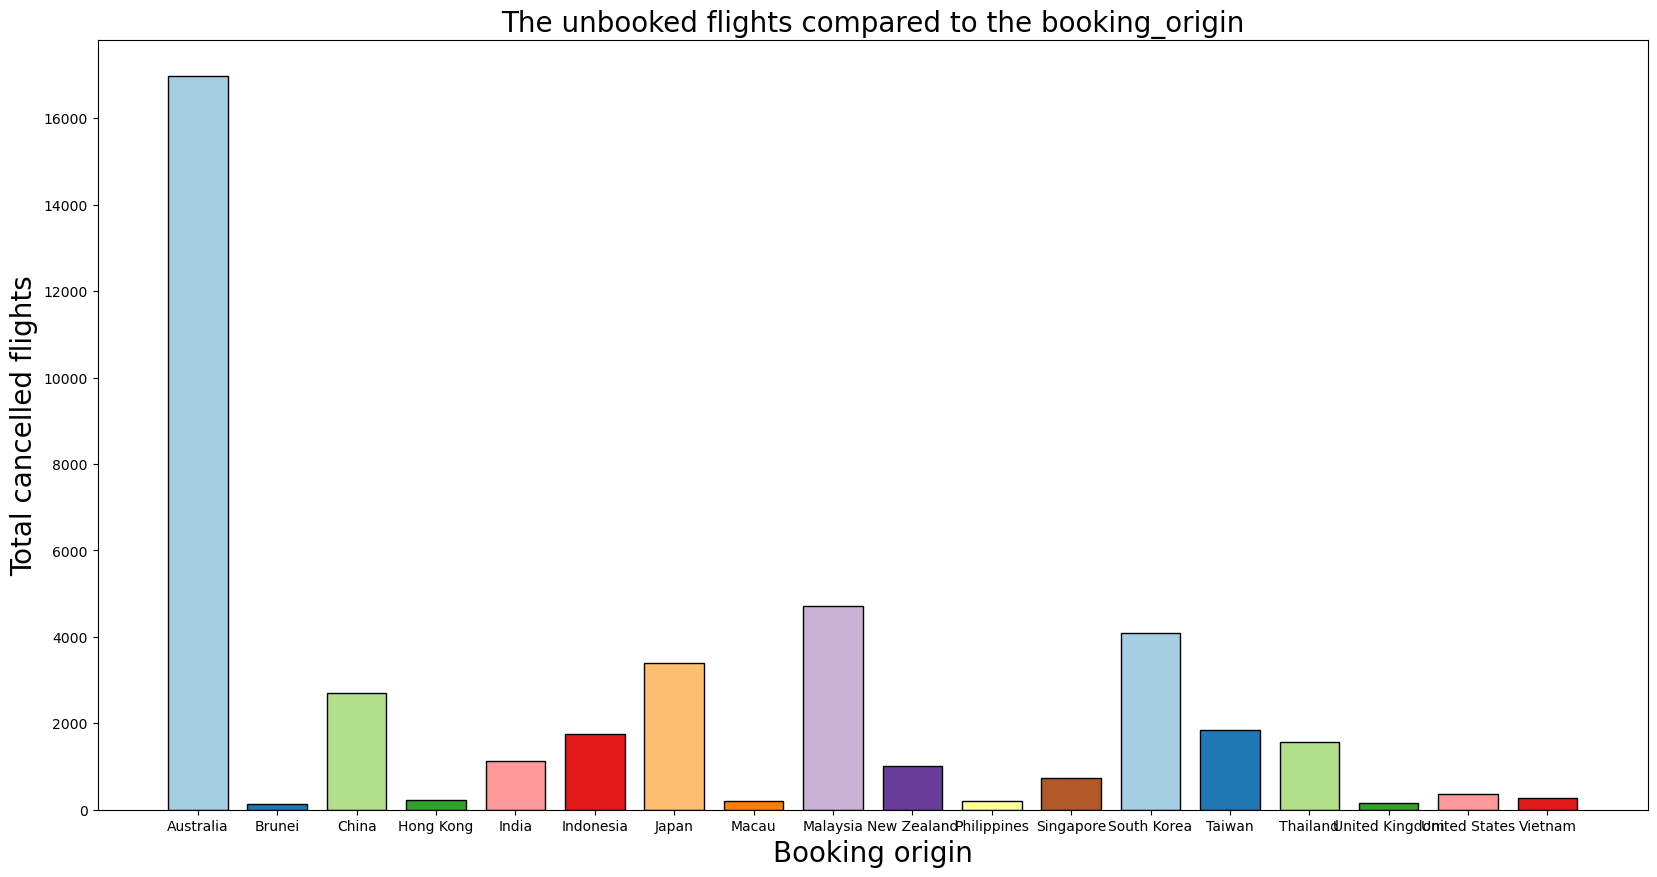

In [120]:
plt.figure(figsize=(20,10))
plt.bar(y.index,y['booking_complete'], width=0.75, color=col_map.colors, edgecolor='k')
plt.xlabel('Booking origin',fontsize=20)
plt.ylabel('Total cancelled flights',fontsize=20)
plt.title('The unbooked flights compared to the booking_origin',fontsize=20 )

##### Most of the booked and cancelled flights are from this countries : australia , china, indonesia , japan , malysia ,new zealand ,india , Taiwan ,sinagpore,Thailand 

### `Flight day\Target`


In [121]:
x2=df[df['booking_complete']==1].groupby('flight_day').count()
x2['booking_complete']

flight_day
Fri     983
Mon    1204
Sat     861
Sun     927
Thu    1122
Tue    1129
Wed    1252
Name: booking_complete, dtype: int64

In [122]:
y2=df[df['booking_complete']==0].groupby('flight_day').count()
y2['booking_complete']

flight_day
Fri    5778
Mon    6898
Sat    4951
Sun    5627
Thu    6302
Tue    6544
Wed    6422
Name: booking_complete, dtype: int64

#### The flight day has no influence in the customer booking action .

### `Route`

In [123]:
df['route'].unique()

array(['AKLDEL', 'AKLHGH', 'AKLHND', 'AKLICN', 'AKLKIX', 'AKLKTM',
       'AKLKUL', 'AKLMRU', 'AKLPEK', 'AKLPVG', 'AKLTPE', 'AORICN',
       'AORKIX', 'AORKTM', 'AORMEL', 'BBIMEL', 'BBIOOL', 'BBIPER',
       'BBISYD', 'BDOCTS', 'BDOCTU', 'BDOHGH', 'BDOICN', 'BDOIKA',
       'BDOKIX', 'BDOMEL', 'BDOOOL', 'BDOPEK', 'BDOPER', 'BDOPUS',
       'BDOPVG', 'BDOSYD', 'BDOTPE', 'BDOXIY', 'BKICKG', 'BKICTS',
       'BKICTU', 'BKIHND', 'BKIICN', 'BKIKIX', 'BKIKTM', 'BKIMEL',
       'BKIMRU', 'BKIOOL', 'BKIPEK', 'BKIPER', 'BKIPUS', 'BKIPVG',
       'BKISYD', 'BKIXIY', 'BLRICN', 'BLRMEL', 'BLRPER', 'BLRSYD',
       'BOMMEL', 'BOMOOL', 'BOMPER', 'BOMSYD', 'BTJJED', 'BTUICN',
       'BTUPER', 'BTUSYD', 'BTUWUH', 'BWNCKG', 'BWNDEL', 'BWNHGH',
       'BWNIKA', 'BWNKTM', 'BWNMEL', 'BWNOOL', 'BWNPER', 'BWNSYD',
       'BWNTPE', 'CANDEL', 'CANIKA', 'CANMEL', 'CANMRU', 'CANOOL',
       'CANPER', 'CANSYD', 'CCUMEL', 'CCUMRU', 'CCUOOL', 'CCUPER',
       'CCUSYD', 'CCUTPE', 'CEBMEL', 'CEBOOL', 'CEBPER', 'CEBS

# VI-Analysis conclusion :
>we can have some hypothesis from the analysis we did:                                                           
`num_passengers,sales_channel,trip_type,purchase_lead,flight_hour,wants_extra_baggage,wants_preferred_seat wants_in_flight_meals` those features have no influence on the target ,  and most of the BA customeres are from those countries australia , china, indonesia , japan , malysia ,new zealand ,india , Taiwan ,sinagpore,Thailand .
We need to balance our data because the classification model might be biased towards the class with the most samples, leading to poor performance on the under-represented class.                                                                                  Also Do the encoding for the non numerical features and remove the duplicates.

# V-Preprocessing

### 1-Drop the duplicates

In [124]:
df_new=df.drop_duplicates()
df_new=df_new.reset_index()

In [125]:
df_new.shape

(49281, 15)

### 2-Encoding

In [126]:
encoder=LabelEncoder()

In [127]:
for column in df.select_dtypes('object'):
    df_new[column]=pd.DataFrame(encoder.fit_transform(df[[column]]))
    

In [128]:
df_new=df_new.drop(['index'],axis=1)

In [129]:
X=df_new.drop(['booking_complete'],axis=1)
Y=df_new['booking_complete']
Y=Y.to_numpy().reshape(-1,1)

### 3-Data balancing:Oversampling

In [130]:
sampler=RandomOverSampler(random_state=0)
x_new,y_new=sampler.fit_resample(X,Y)

### 4-Scaling

In [131]:
scaler=MinMaxScaler()
x_new[['num_passengers','trip_type','purchase_lead','length_of_stay','flight_hour','flight_day','route','booking_origin','flight_duration']]=scaler.fit_transform(x_new[['num_passengers','trip_type','purchase_lead','length_of_stay','flight_hour','flight_day','route','booking_origin','flight_duration']])

### 5-Feature selection

In [132]:
selected_features = mutual_info_classif(x_new,y_new)
selected_features = pd.Series(selected_features, name="MI Scores", index=X.columns)
selected_features = selected_features.sort_values(ascending=False)

Text(0.5, 1.0, 'Feature influence on the target ')

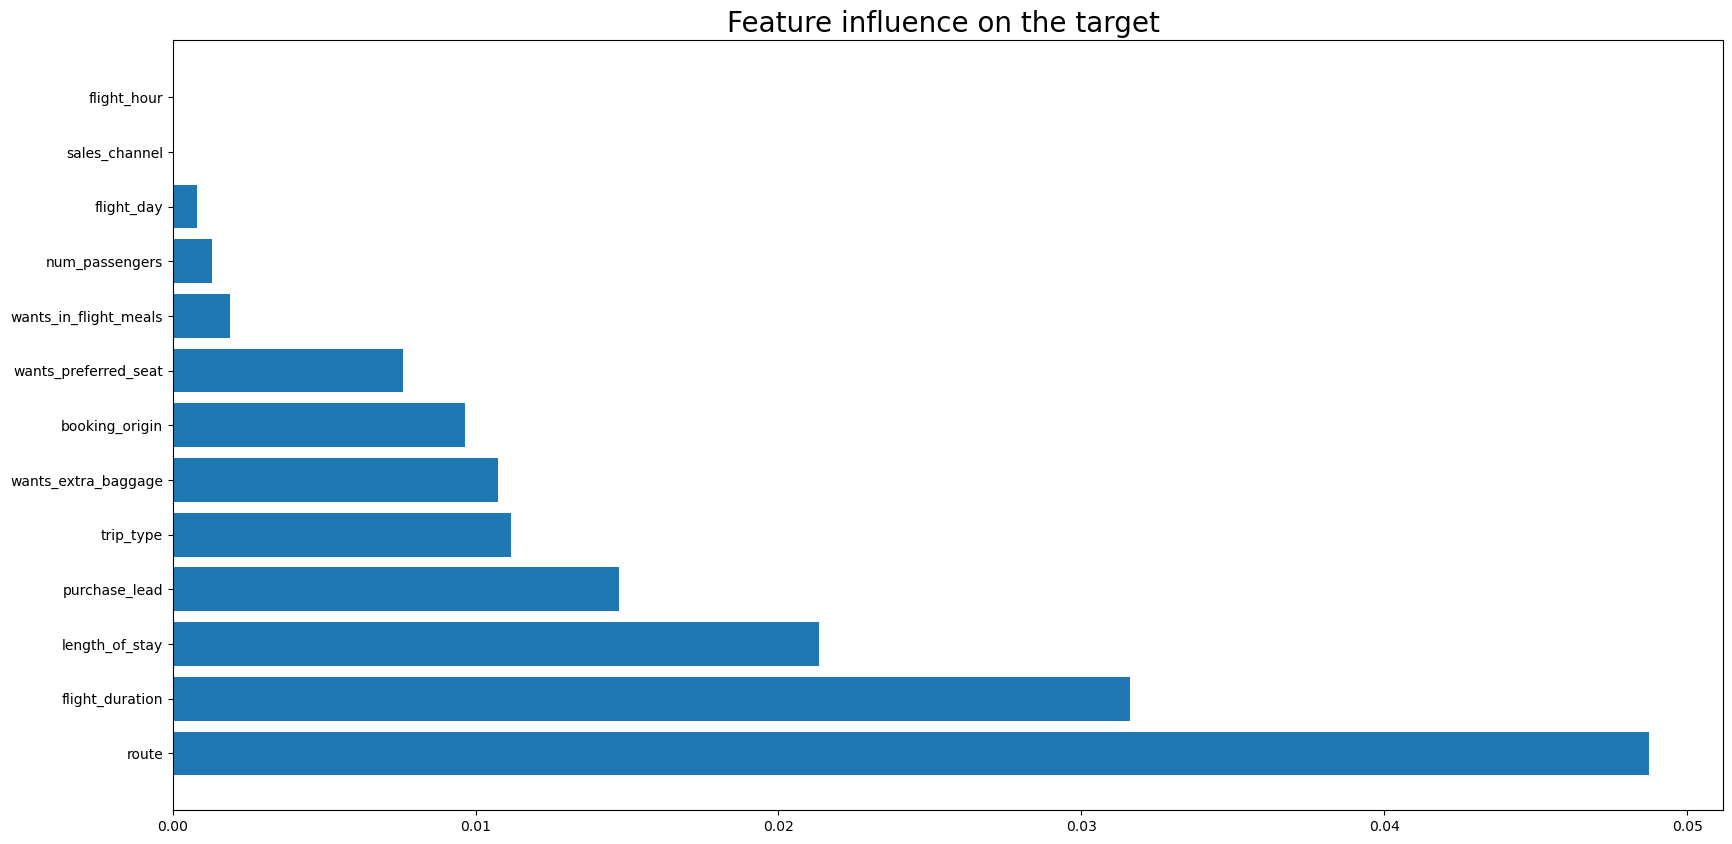

In [133]:
plt.figure(figsize=(20,10))
plt.barh(selected_features.index,selected_features)
plt.title('Feature influence on the target ',fontsize=20)

#### Our data analysis hypothesis are matching the feature selection model result 

# VI-Modelization and Evaluation

We have a classification problem so we are using these models and choosing the most efficient one among them :
>Decision Tree,
>Random Forest,
>k-Nearest Neighbors (k-NN),

In [134]:
x_train,x_test,y_train,y_test=train_test_split(x_new,y_new,test_size=0.2)

In [135]:
X_5=x_new.drop(['num_passengers','sales_channel','trip_type','flight_hour','flight_day','wants_extra_baggage','wants_preferred_seat','wants_in_flight_meals'],axis=1)
x_top5_train,x_top5_test,y_train,y_test=train_test_split(X_5,y_new,test_size=0.2)

In [136]:
X_3=x_new.drop(['num_passengers','sales_channel','trip_type','purchase_lead','flight_hour','flight_day','wants_extra_baggage','wants_preferred_seat','wants_in_flight_meals'],axis=1)
x_top3_train,x_top3_test,y_train,y_test=train_test_split(X_3,y_new,test_size=0.2)

## Decision Tree classifier

In [137]:
DecisionTree=DecisionTreeClassifier()

#### Decision Tree  performance with all the features

accuracy 49.70756743852948
[[4598 3791]
 [4636 3731]]
              precision    recall  f1-score   support

           0       0.50      0.55      0.52      8389
           1       0.50      0.45      0.47      8367

    accuracy                           0.50     16756
   macro avg       0.50      0.50      0.50     16756
weighted avg       0.50      0.50      0.50     16756



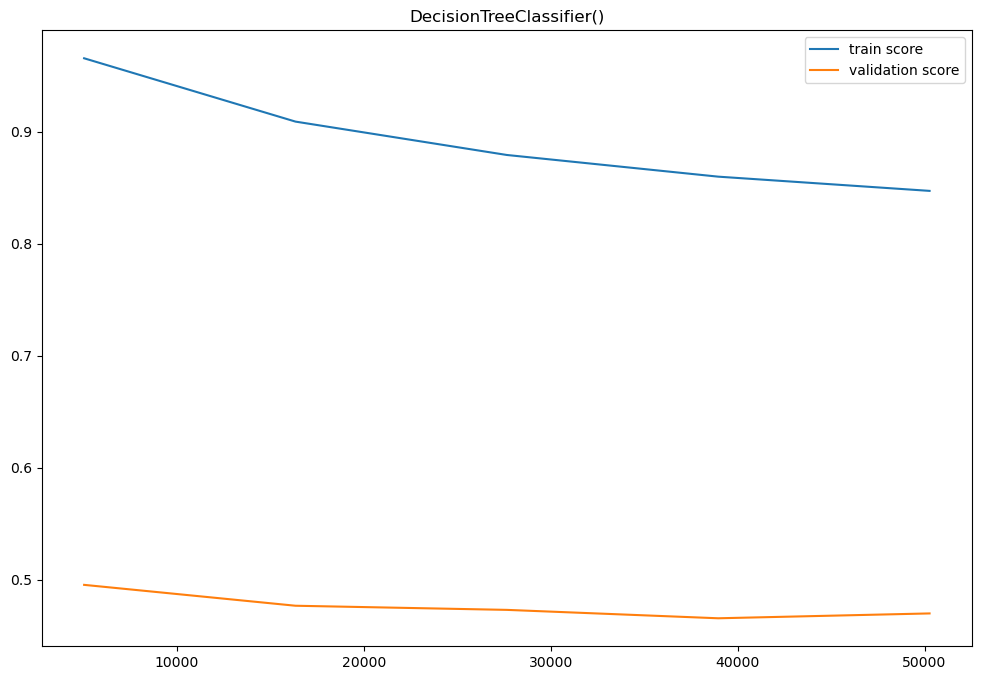

In [138]:
evaluation_confusion_matrix(DecisionTree,x_train,x_test,y_train,y_test)


####  Decision Tree performance with top5 features

accuracy 49.970159942707085
[[4696 3693]
 [4690 3677]]
              precision    recall  f1-score   support

           0       0.50      0.56      0.53      8389
           1       0.50      0.44      0.47      8367

    accuracy                           0.50     16756
   macro avg       0.50      0.50      0.50     16756
weighted avg       0.50      0.50      0.50     16756



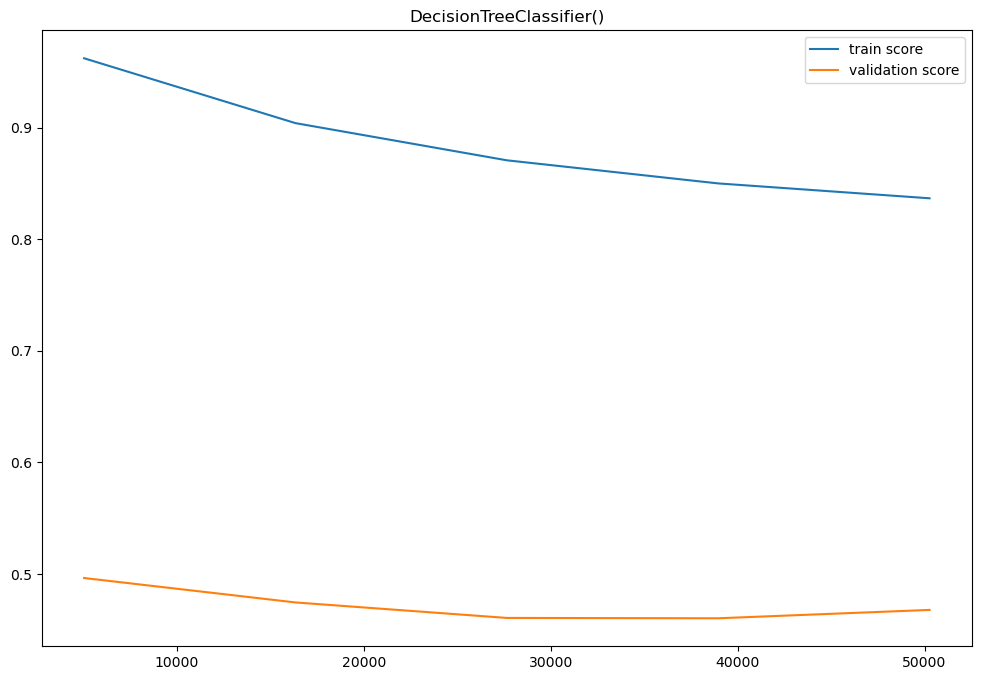

In [139]:
evaluation_confusion_matrix(DecisionTree,x_top5_train,x_top5_test,y_train,y_test)

####  Decision Tree performance with top3 features


accuracy 79.10002387204584
[[5841 2548]
 [ 954 7413]]
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      8389
           1       0.74      0.89      0.81      8367

    accuracy                           0.79     16756
   macro avg       0.80      0.79      0.79     16756
weighted avg       0.80      0.79      0.79     16756



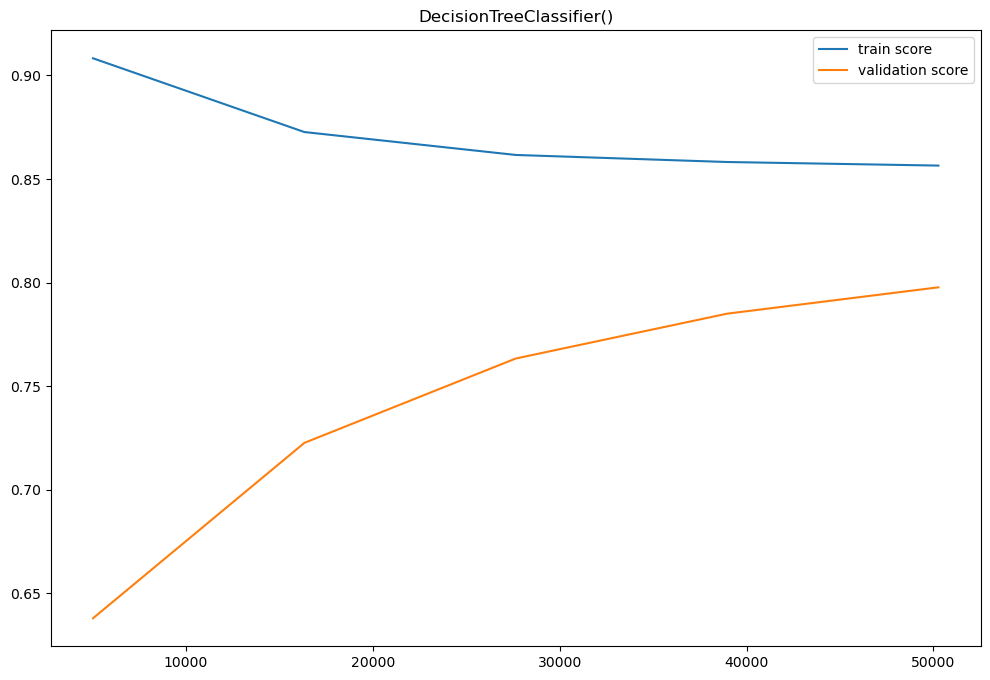

In [140]:
evaluation_confusion_matrix(DecisionTree,x_top3_train,x_top3_test,y_train,y_test)

## Kneighobrs classifier

In [141]:
knn=KNeighborsClassifier()

#### Kneighobrs performance with all the features:

accuracy 49.74934351873956
[[4165 4224]
 [4196 4171]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      8389
           1       0.50      0.50      0.50      8367

    accuracy                           0.50     16756
   macro avg       0.50      0.50      0.50     16756
weighted avg       0.50      0.50      0.50     16756



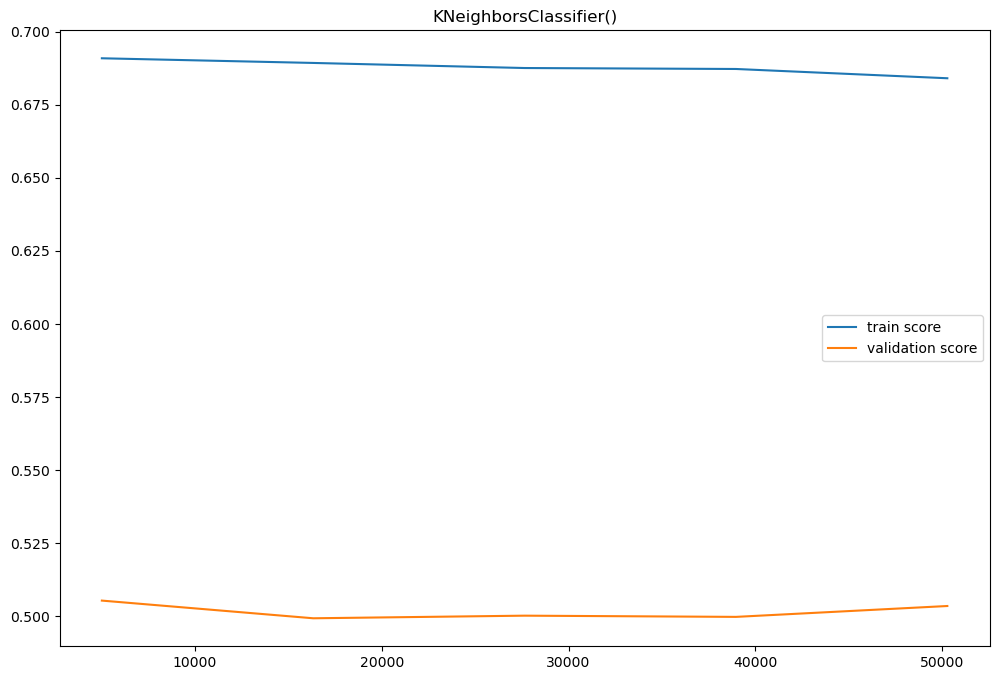

In [142]:
evaluation_confusion_matrix(knn,x_train,x_test,y_train,y_test)

#### Kneighobrs performance with top 5 features:

accuracy 49.71950346144665
[[4182 4207]
 [4218 4149]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      8389
           1       0.50      0.50      0.50      8367

    accuracy                           0.50     16756
   macro avg       0.50      0.50      0.50     16756
weighted avg       0.50      0.50      0.50     16756



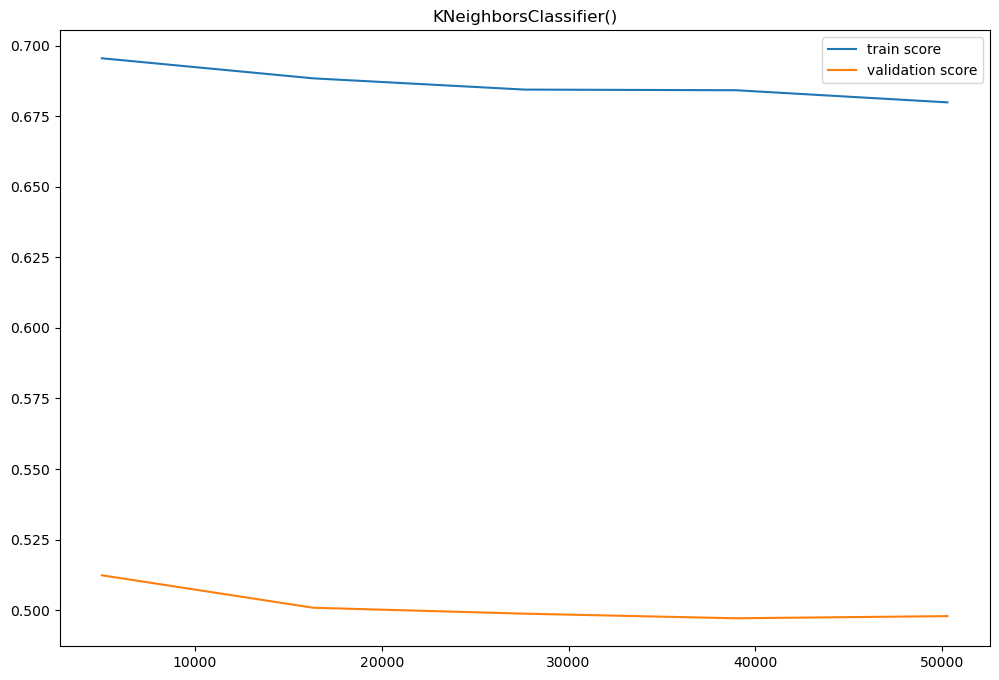

In [143]:
evaluation_confusion_matrix(knn,x_top5_train,x_top5_test,y_train,y_test)

#### Kneighobrs performance with top 3 features:

accuracy 73.32895679159705
[[5375 3014]
 [1455 6912]]
              precision    recall  f1-score   support

           0       0.79      0.64      0.71      8389
           1       0.70      0.83      0.76      8367

    accuracy                           0.73     16756
   macro avg       0.74      0.73      0.73     16756
weighted avg       0.74      0.73      0.73     16756



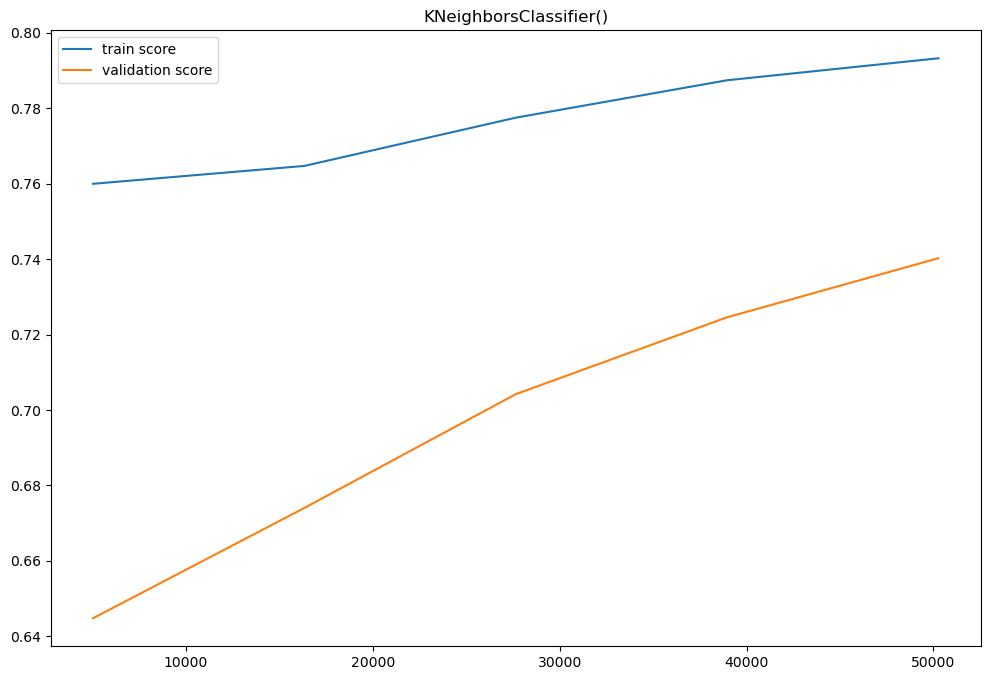

In [144]:
evaluation_confusion_matrix(knn,x_top3_train,x_top3_test,y_train,y_test)

## RandomForest

In [145]:
Randomforest=RandomForestClassifier()

#### RandomForest performance with all the features:

accuracy 49.91644783957985
[[4207 4182]
 [4210 4157]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      8389
           1       0.50      0.50      0.50      8367

    accuracy                           0.50     16756
   macro avg       0.50      0.50      0.50     16756
weighted avg       0.50      0.50      0.50     16756



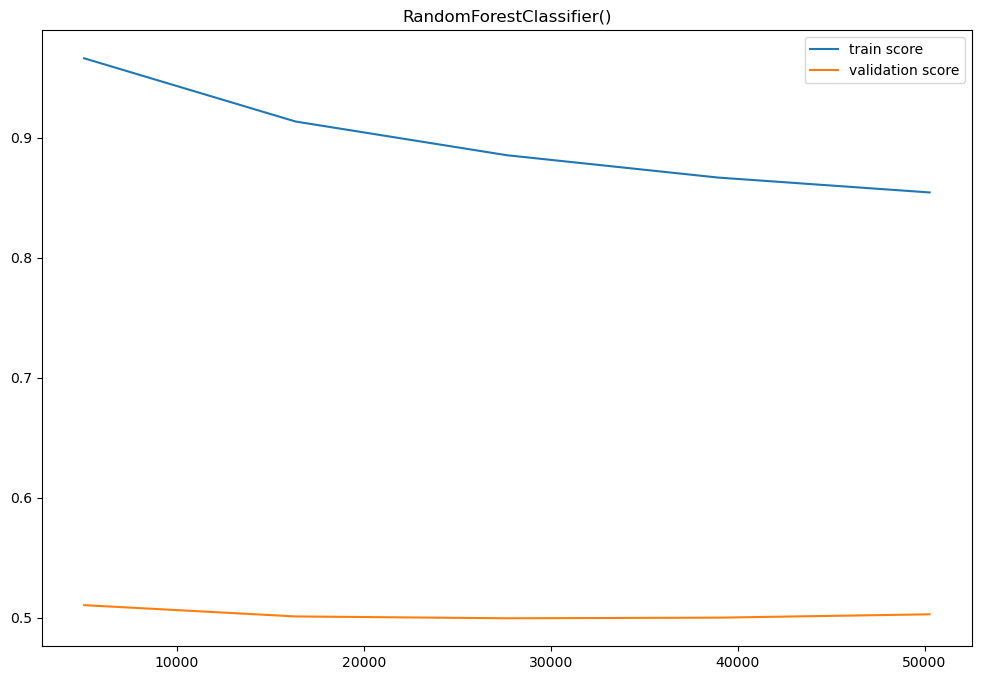

In [146]:
evaluation_confusion_matrix(Randomforest,x_train,x_test,y_train,y_test)

#### RandomForest performance with top 5 features:

accuracy 49.84483170207687
[[4222 4167]
 [4237 4130]]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      8389
           1       0.50      0.49      0.50      8367

    accuracy                           0.50     16756
   macro avg       0.50      0.50      0.50     16756
weighted avg       0.50      0.50      0.50     16756



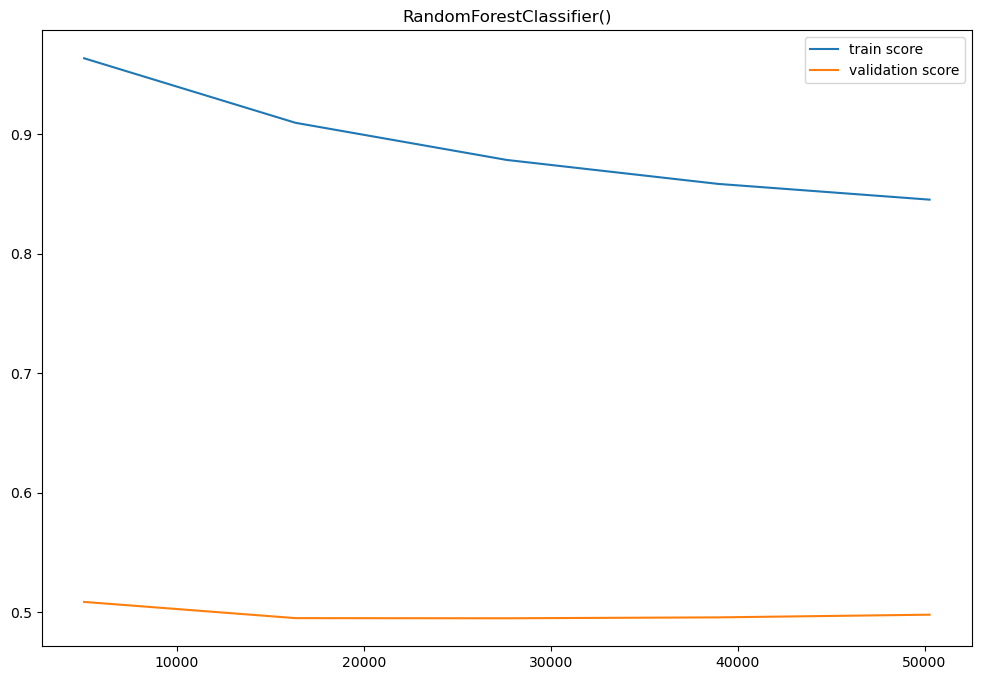

In [147]:
evaluation_confusion_matrix(Randomforest,x_top5_train,x_top5_test,y_train,y_test)

#### RandomForest performance with top 3 features:

accuracy 79.95344951062306
[[5871 2518]
 [ 841 7526]]
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      8389
           1       0.75      0.90      0.82      8367

    accuracy                           0.80     16756
   macro avg       0.81      0.80      0.80     16756
weighted avg       0.81      0.80      0.80     16756



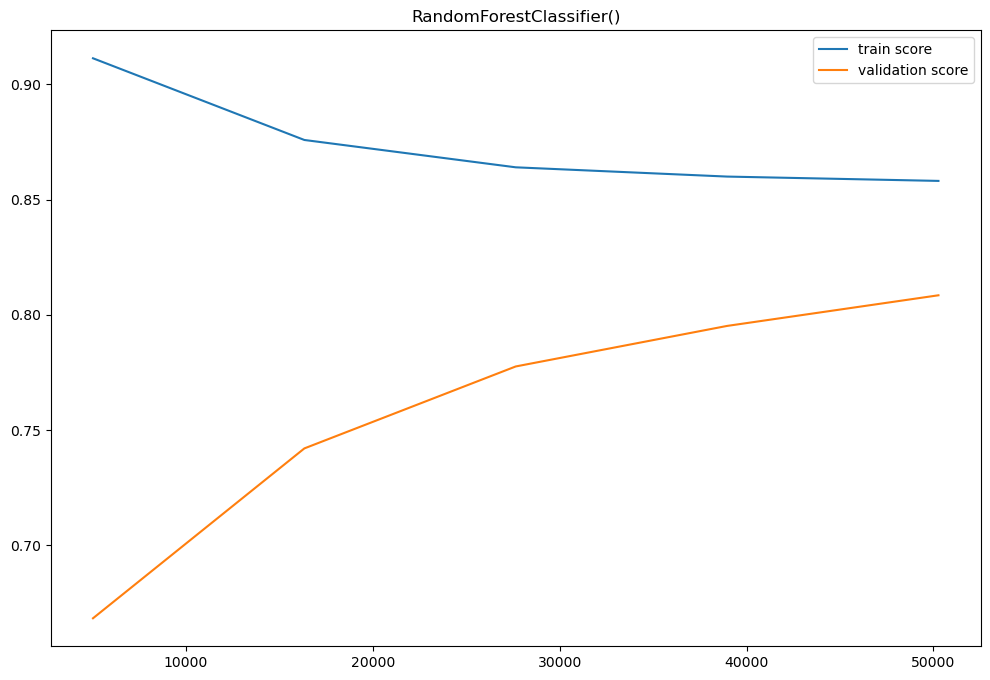

In [148]:
evaluation_confusion_matrix(Randomforest,x_top3_train,x_top3_test,y_train,y_test)

#### All the predicting models have better performance with the top3 features (route,flight_duration,length_of_stay) specially Random forest.

# VII-Optimization:

In [161]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
  
}


In [162]:
grid=grid_search = GridSearchCV(estimator=Randomforest, param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(x_top3_train,y_train)
print(grid.best_params_)

{'max_depth': 20, 'n_estimators': 100}


accuracy 80.0071616137503
[[5880 2509]
 [ 841 7526]]
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      8389
           1       0.75      0.90      0.82      8367

    accuracy                           0.80     16756
   macro avg       0.81      0.80      0.80     16756
weighted avg       0.81      0.80      0.80     16756



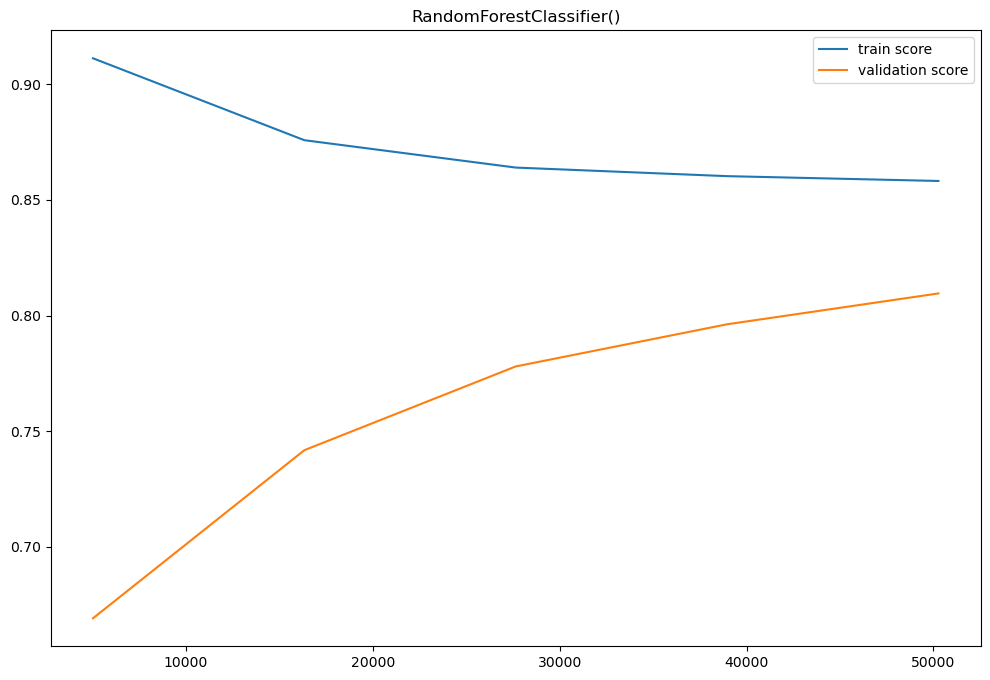

In [164]:
RandomFores=RandomForestClassifier(n_estimators=100,max_depth=20)
evaluation_confusion_matrix(Randomforest,x_top3_train,x_top3_test,y_train,y_test)

#### The model accuarcy slightly increased by choosing the most efficient hyperparameters

# Conclusion:

>From the data analysis and modelization we can conclude that the `Route,Lenghth_of_stay,flight_duration` are the responsible features for the customer decision whether to book or not so as solution the airline needs to work on optimizing the flights route, flight duration this can be accomplished through the use of mathematical algorithms, flight simulation software, and weather forecasting tools .